In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import os
import math
from scipy import signal
import random
import keras
from keras import layers
import tensorflow as tf

In [2]:
def min_max_scaling(d):
    min_val = min(d)
    max_val = max(d)
    scaled_data = [(x - min_val) / (max_val - min_val) for x in d]
    return scaled_data

In [3]:
days = [name for name in os.listdir("/Users/henrywang/Documents/PPGBloodGlucosePrediction/CaffeineReadings/6-26Readings") if os.path.isdir(os.path.join("/Users/henrywang/Documents/PPGBloodGlucosePrediction/CaffeineReadings/6-26Readings", name))]
days

['2024-07-03', '2024-07-02', '2024-07-05', '2024-06-28', '2024-06-26']

In [4]:
data = []
label = []

lengths = []
dataLabelDictionary = {}
for day in days:
    for file in os.listdir("/Users/henrywang/Documents/PPGBloodGlucosePrediction/CaffeineReadings/6-26Readings/" + day):
        time, y1, y2 = np.loadtxt("/Users/henrywang/Documents/PPGBloodGlucosePrediction/CaffeineReadings/6-26Readings/" + day + "/" + file, delimiter = ",", unpack=True)
        name = file[:-4]
        fpass = [0.7, 4]  # Passband frequency range
        order = 2  # Filter order
        y1 = -y1[20:]
        y2 = -y2[20:]
        data.append([y1, y2])
        lengths.append(len(y1))
        if name == "5MinAfterReading" or name == "45MinAfterReading":
            label.append("After")
        else:
            label.append("Before")
print(min(lengths))

17865


In [6]:
from numpy.polynomial.polynomial import Polynomial

def detrend_polynomial(data, degree = 2):
    x = np.arange(len(data))
    poly = Polynomial.fit(x, data, degree)
    trend = poly(x)
    return data - trend


import numpy as np

def difference(data):
    return np.diff(data, n=1)

def moving_average_np(data, window_size = 5):
    """
    Apply a moving average filter to the input data using numpy.

    Parameters:
    - data: numpy array or list, the input time series data.
    - window_size: int, size of the moving average window.

    Returns:
    - smoothed_data: numpy array, the smoothed time series data.
    """
    # Define the kernel for the moving average
    kernel = np.ones(window_size) / window_size

    # Apply the moving average filter
    smoothed_data = np.convolve(data, kernel, mode='same')

    return smoothed_data



Creating train and test dataset

1065
295


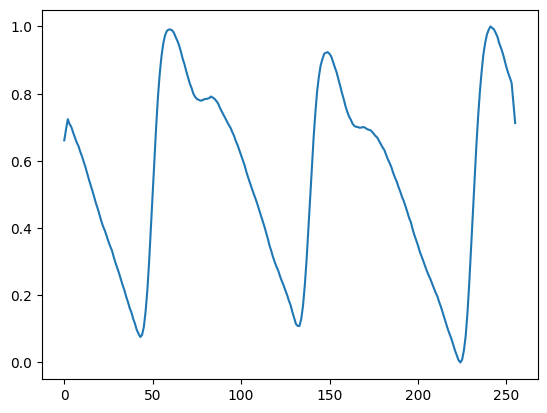

In [16]:
train_x0 = []
train_x1 = []
train_x = []
train_y = []
test_x0 = []
test_x1 = []
test_x = []
test_y = []

trainTestThreshold = 0.8
length = len(data)


zipped = list(zip(data, label))

random.shuffle(zipped)

randomizedList = list(zip(*zipped))

randomData = randomizedList[0]
randomLabel = randomizedList[1]

labelToNumeric = {"After": 1, "Before": 0}
intervalLength = 256
count = 0
for index in range(length):
    for i in range(0, 17500 - intervalLength, intervalLength):
        seed = random.random()
        if seed < trainTestThreshold:
            train_x0.append(min_max_scaling(moving_average_np(detrend_polynomial(randomData[index][0][i: i + intervalLength]))))
            train_x1.append(min_max_scaling(moving_average_np(detrend_polynomial(randomData[index][1][i: i + intervalLength]))))
            train_y.append(labelToNumeric[randomLabel[index]])
        else:
            test_x0.append(min_max_scaling(moving_average_np(detrend_polynomial(randomData[index][0][i: i + intervalLength]))))
            test_x1.append(min_max_scaling(moving_average_np(detrend_polynomial(randomData[index][1][i: i + intervalLength]))))
            test_y.append(labelToNumeric[randomLabel[index]])

train_x0 = np.asarray(train_x0)
train_x1 = np.asarray(train_x1)

train_y = np.asarray(train_y)
test_x0 = np.asarray(test_x0)
test_x1 = np.asarray(test_x1)

test_y = np.asarray(test_y)

print(len(train_x1))
print(len(test_x1))

example = train_x1[0]
plt.plot(train_x1[0])



In [36]:
from keras.regularizers import l2
fingerSequentialInput = keras.Input(shape = (intervalLength))
toeSequentialInput = keras.Input(shape = (intervalLength))


fingerCNN = layers.Dense(256)(fingerSequentialInput)
toeCNN = layers.Dense(256)(toeSequentialInput)

fingerBatchNorm1 = layers.BatchNormalization()(fingerCNN)
toeBatchNorm1 = layers.BatchNormalization()(toeCNN)

fingerActivation1 = layers.Activation('relu')(fingerBatchNorm1)
toeActivation1 = layers.Activation('relu')(toeBatchNorm1)

fingerCNN2 = layers.Dense(256)(fingerActivation1)
toeCNN2 = layers.Dense(256)(toeActivation1)


# finger2d500_1  = layers.Reshape((intervalLength, 1))(fingerSequentialInput)
# toe2d500_1  = layers.Reshape((intervalLength, 1))(toeSequentialInput)

fingerReduce2 = layers.Conv1D(filters=1, kernel_size=4, strides=4, padding='valid')(finger2d500_1)


toeReduce2 = layers.Conv1D(filters=1, kernel_size=4, strides=4, padding='valid')(toe2d500_1)


fingerReshape2 = layers.Reshape((64,))(fingerReduce2)
toeReshape2 = layers.Reshape((64,))(toeReduce2)
# fingerReduce = layers.Conv1D(filters=1, kernel_size=32, strides=30, padding='valid', activation='relu')(finger2d500)
# toeReduce = layers.Conv1D(filters=1, kernel_size=32, strides=30, padding='valid', activation='relu')(toe2d500)

fingerAdd = layers.add([fingerCNN2, fingerSequentialInput])
toeAdd = layers.add([toeCNN2, toeSequentialInput])

fingerActivation1 = layers.Activation('relu')(fingerAdd)
toeActivation1 = layers.Activation('relu')(toeAdd)
#___________________________________ Residual block
fingerCNN2 = layers.Dense(64)(fingerActivation1)
toeCNN2 = layers.Dense(64)(toeActivation1)


finger2d  = layers.Reshape((64, 1))(fingerCNN2)
toe2d  = layers.Reshape((64, 1))(toeCNN2)

fingerLSTM = layers.Bidirectional(layers.LSTM(16))(finger2d)
toeLSTM = layers.Bidirectional(layers.LSTM(16))(toe2d)


fingerCNN = layers.Dense(16, activation = "relu")(fingerLSTM)

toeCNN = layers.Dense(16, activation = "relu")(toeLSTM)


mergedLayer = layers.Concatenate()([fingerCNN, toeCNN])


finalOutput3 = layers.Dense(16, activation = "relu")(mergedLayer)
finalDropout = layers.Dropout(0.5)(finalOutput3)

finalOutput2 = layers.Dense(8, activation = "relu")(finalOutput3)
finalDropout = layers.Dropout(0.5)(finalOutput2)
finalOutput = layers.Dense(1, activation = "sigmoid")(finalDropout)

mergeEpoch = 150
mergedModel = keras.Sequential()
mergedModel.reset_states()
mergedModel = keras.models.Model(inputs = [fingerSequentialInput, toeSequentialInput], outputs = finalOutput)
mergedModel.summary()

adamMergeOptimizer = keras.optimizers.legacy.Adam(learning_rate = 0.0001)
# reduceLR = keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10)
mergedModel.compile(optimizer = adamMergeOptimizer, loss = "binary_crossentropy", metrics = ['accuracy'])


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 input_26 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 dense_119 (Dense)           (None, 256)                  65792     ['input_25[0][0]']            
                                                                                                  
 dense_120 (Dense)           (None, 256)                  65792     ['input_26[0][0]']            
                                                                                           

In [38]:
mergeEpoch = 50
mergeHistory = mergedModel.fit(x = [train_x0, train_x1], y = train_y, validation_data=([test_x0, test_x1], test_y), batch_size=32, epochs = mergeEpoch)


Epoch 1/50
34/34 [==============================] - 2s 53ms/step - loss: 0.4582 - accuracy: 0.7728 - val_loss: 0.6464 - val_accuracy: 0.6983
Epoch 2/50
34/34 [==============================] - 2s 57ms/step - loss: 0.4800 - accuracy: 0.7775 - val_loss: 0.6391 - val_accuracy: 0.6915
Epoch 3/50
34/34 [==============================] - 2s 50ms/step - loss: 0.4782 - accuracy: 0.7850 - val_loss: 0.6509 - val_accuracy: 0.6814
Epoch 4/50
34/34 [==============================] - 2s 48ms/step - loss: 0.4625 - accuracy: 0.7859 - val_loss: 0.7205 - val_accuracy: 0.6644
Epoch 5/50
34/34 [==============================] - 2s 46ms/step - loss: 0.4483 - accuracy: 0.7981 - val_loss: 0.6973 - val_accuracy: 0.6712
Epoch 6/50
34/34 [==============================] - 2s 47ms/step - loss: 0.4469 - accuracy: 0.8085 - val_loss: 0.6803 - val_accuracy: 0.6712
Epoch 7/50
34/34 [==============================] - 2s 50ms/step - loss: 0.4512 - accuracy: 0.7991 - val_loss: 0.6719 - val_accuracy: 0.6610
Epoch 8/50
34

10/10 [==============================] - 2s 70ms/step


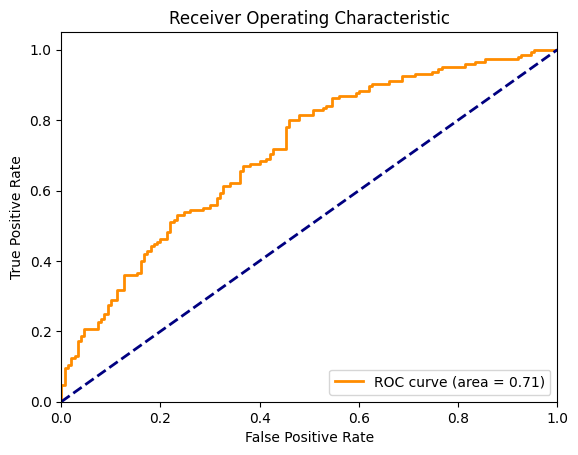

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
y_scores = mergedModel.predict([test_x0, test_x1])
y_true = test_y
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Compute the AUC
roc_auc = roc_auc_score(y_true, y_scores)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#Maybe use fourier transofmr as input

34/34 [==============================] - 1s 25ms/step


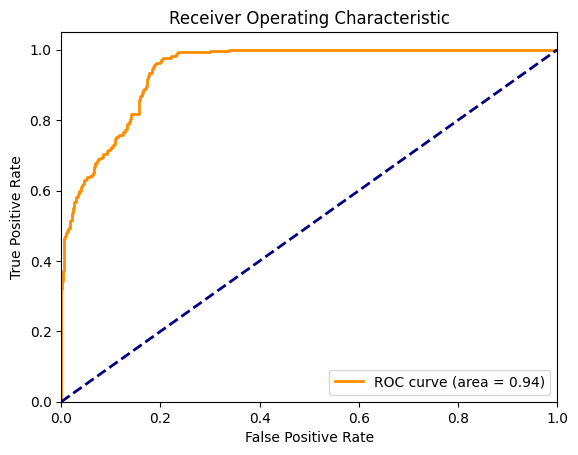

In [40]:
y_scores = mergedModel.predict([train_x0, train_x1])
y_true = train_y
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Compute the AUC
roc_auc = roc_auc_score(y_true, y_scores)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

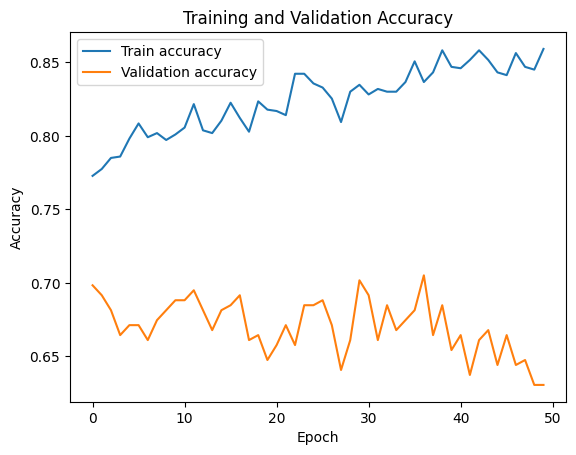

In [41]:
plt.plot(mergeHistory.history['accuracy'], label='Train accuracy')
plt.plot(mergeHistory.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

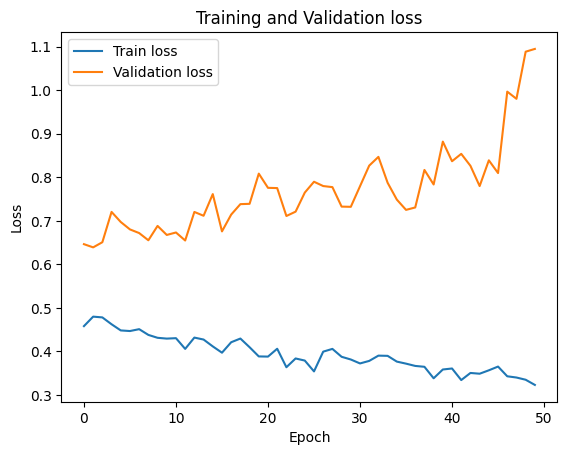

In [42]:
plt.plot(mergeHistory.history['loss'], label='Train loss')
plt.plot(mergeHistory.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [84]:
a = list(mergedModel.predict([train_x0, train_x1]))
b = [ab[0] for ab in a]
b

34/34 [==============================] - 0s 2ms/step


[0.172388,
 0.19078708,
 0.23702976,
 0.16020958,
 0.3309249,
 0.3564121,
 0.16319276,
 0.24010703,
 0.41269222,
 0.20365687,
 0.17986706,
 0.2735247,
 0.16352174,
 0.5120556,
 0.18625586,
 0.12006764,
 0.07814461,
 0.09902664,
 0.0831463,
 0.0535419,
 0.12406823,
 0.17915267,
 0.18217827,
 0.16633211,
 0.32279536,
 0.22378153,
 0.2878245,
 0.103135,
 0.12100036,
 0.14492239,
 0.12256296,
 0.14693736,
 0.097513616,
 0.08830372,
 0.08069374,
 0.08655873,
 0.3051505,
 0.11228697,
 0.08675256,
 0.1909172,
 0.192671,
 0.28539106,
 0.16636772,
 0.13296424,
 0.14869666,
 0.27742383,
 0.2951567,
 0.09313639,
 0.13528307,
 0.18444727,
 0.54693013,
 0.68185824,
 0.8360928,
 0.8010157,
 0.7478658,
 0.696903,
 0.66041625,
 0.7816365,
 0.8102834,
 0.694855,
 0.80324644,
 0.7718062,
 0.84160733,
 0.7442252,
 0.781227,
 0.74621314,
 0.82004595,
 0.7692599,
 0.75620705,
 0.8210917,
 0.826027,
 0.692072,
 0.655239,
 0.7741557,
 0.8355493,
 0.7864743,
 0.67106664,
 0.81902367,
 0.80030805,
 0.7706112,


(array([176., 163.,  99.,  47.,  53.,  41.,  53.,  98., 225., 132.]),
 array([0.04585392, 0.12790026, 0.20994659, 0.29199293, 0.37403926,
        0.45608559, 0.53813195, 0.62017828, 0.70222461, 0.78427094,
        0.86631727]),
 <BarContainer object of 10 artists>)

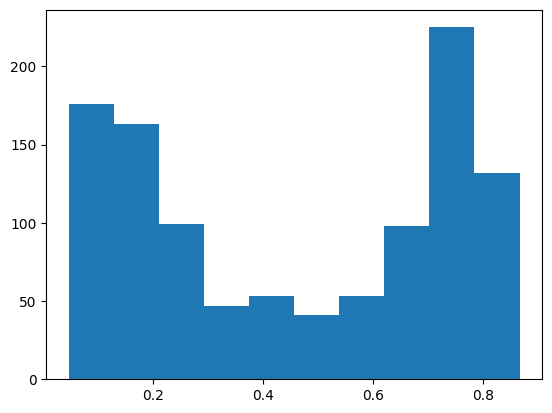

In [85]:
plt.hist(b)